# Retención proactiva de clientes bancarios

## DM EyF 2024 - UBA

## Experimento combinando Árboles con Redes Neuronales

Comisión: lunes

Alumno: Santiago Tedoldi


## Motivación

La supremacía de los modelos basados en árboles para la resolución de problemas con datos tabulares podría ser cuestionada a la luz del desarrollo de modelos de IA cada vez más complejos y sofisticados. Estos nuevos modelos han demostrado resolver con éxito problemas con datos no tabulados, como imágenes, lenguaje e incluso en problemas multimodelas (por ejemplo: images-texto).

Las redes convolucionales, en imágenes, y los transformers, principalmente para texto, pueden considerarse el estado del arte para muchos problemas complejos. Ahora bien, ¿es posible aprovechar estos desarrollos en problemas como la retención proactiva de clientes?

En mi trabajo, durante el desarrollo de modelos analíticos de riesgo aduanero, tuve la oportunidad de probar arquitecturas que combinan árboles con redes neuronales y mecanismos de atención. Los resultados obtenidos para esos casos son prometedores, aunque ningún modelo semejante haya entrado aún en producción.

En este experimento pretendo ensayar un modelo que combine un bosque pre-entrenado (GBDTs), idéntico a los optimizados para el problema de retención de clientes bancarios, una capa de embedding que codifica las hojas activas (cross-features) por cada cliente. Esta combinación de bosque y capa de embedding recibe el nombre de **Tree-based Cross-Feature Embedding**.

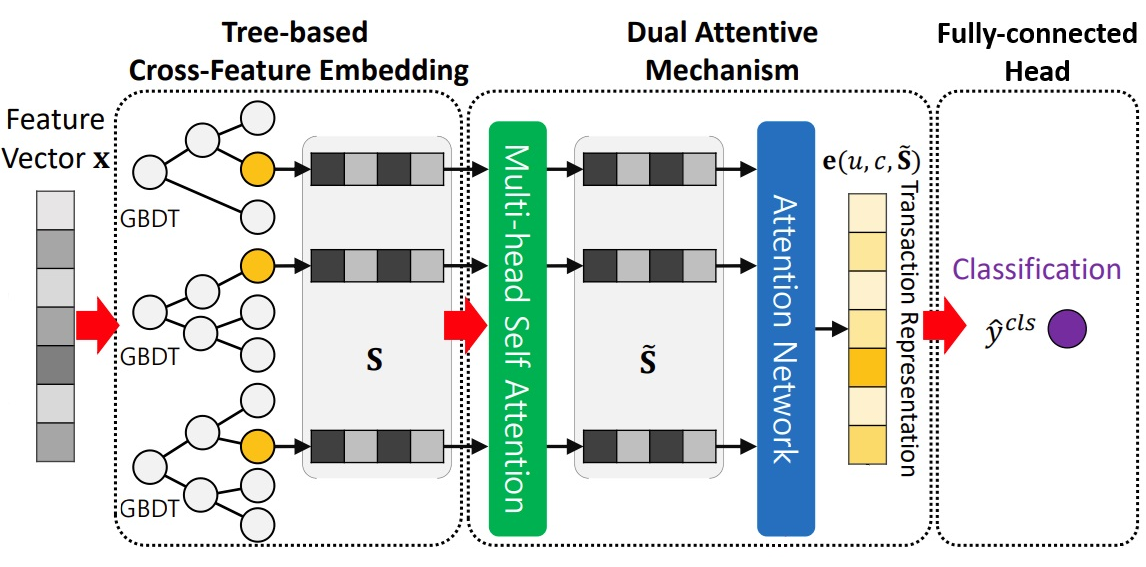

Opcionalmente, la representación de cada hoja activa (cross-feature) se procesa en una capa de self-attention con 4 cabezas busca adaptarlas según el "contexto" (otras hojas activas para el mismo cliente).

Tras el proceso de self-attention, las representaciones de las 100 hojas activas (cross-feature) se agregan (por ejemplo, sumándose) y normalizan. Otra matriz de atención, también opcional, que bien podría permitir el "cruce" con otros embeddings significativos para el problema, se aplica para obtener una representación latente de cada cliente.

Al final, un arreglo fully-connected termina de procesar cada caso, usa su representación latente del cliente para llegar a la seudo-probabilidad de su baja.

## Bibliografía

Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need

Sundong Kim, Yu-Che Tsai, Karandeep Singh, Yeonsoo Choi, Etim Ibok, Cheng-Te Li, Meeyoung Cha. 2020. DATE: Dual Attentive Tree-aware Embedding for Customs Fraud Detection

## Dependencia

In [56]:
# Importar las librerías necesarias
import os
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

## Directorios

In [57]:
datos = 'datos'
optimizacion = 'optimizacion'
modelos = 'modelos'
resultados = 'resultados'

## Condiciones de entrenamiento

Entrenamos con la mejor optimización posible, sobre el último més disponible.

Ya tenemos en nuestras variables, algunas variables históricas según el feature engineering aplicado.

In [58]:
ganancia_acierto = 273000
costo_estimulo = 7000

# mes_train = [202104] 
mes_train = [202102, 202103, 202104] # agrego más meses para el train

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

In [59]:
max_jobs = os.cpu_count() - 6

## Ensamble

XGBoost + Redes neuronales

Usando el XGBoost optimizado para la competencia 01, vamos a desarrollar un modelo de ensamble con redes neuronales y mecanismos de atención.

### 1. XGBoost re-entrenado

Datos

In [60]:
dataset_file = 'competencia_01_brandoni_fe_agr_3.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

# data cleansing + data drifting
to_drop = ['Master_fultimo_cierre', 'Visa_fultimo_cierre'] + ['cprestamos_personales', 'mprestamos_personales']

C:\Users\santt\AppData\Local\Temp\ipykernel_25856\217547193.py:5: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_file)


Target ternaria

In [61]:
data

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,comisiones_mantenimiento_slope_2_foto_mes_10tile,comisiones_mantenimiento_slope_3_foto_mes_10tile,comisiones_otras_slope_1_foto_mes_10tile,comisiones_otras_slope_2_foto_mes_10tile,comisiones_otras_slope_3_foto_mes_10tile,ratio_saldo_margen_10tile,total_comisiones_cliente_10tile,transacciones_totales_tarjetas_10tile,delta_debito_vs_credito_10tile,indicador_banca_digital_10tile
0,1128309822,202102,1,0,0,44,68,2659.60,8862.12,2641.37,...,9,2,3,7,9,1,10,2,7,1
1,606189310,202102,1,0,0,48,61,2697.63,35957.55,2687.24,...,9,10,10,10,10,2,10,2,7,1
2,624696887,202102,1,0,0,62,59,4498.27,88573.39,2703.46,...,4,5,7,4,2,10,10,2,7,1
3,1324320343,202102,1,0,0,28,39,2777.98,8153.01,2777.04,...,6,8,9,5,3,1,10,2,7,1
4,770236409,202102,1,0,0,52,124,3210.98,28548.03,3102.91,...,10,2,3,7,4,10,10,2,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981941,287385592,202104,1,0,0,64,180,-2062.70,10252.34,973.34,...,4,3,6,2,9,4,5,9,10,10
981942,1070171132,202104,1,0,0,31,84,7424.01,76160.14,1874.92,...,8,8,4,9,9,9,7,5,10,10
981943,1080005276,202104,1,0,0,34,80,7449.61,141623.05,1211.90,...,4,3,6,10,1,7,6,5,10,10
981944,954640364,202104,1,0,0,33,93,896.98,5887.66,651.85,...,4,6,8,5,6,10,4,7,10,10


In [62]:
target_multi = 'clase_ternaria'

# X = data[data['foto_mes'] == mes_train]
X = data.loc[data['foto_mes'].isin(mes_train)] # para este caso, la optimización antes hecha queda obsoleta
y = X[target_multi]
X = X.drop(columns=[target_multi])

In [63]:
# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

y = y.map(label_mapping)

y.value_counts()

clase_ternaria
0    484447
2      3187
1      2787
Name: count, dtype: int64

Target binaria

In [64]:
y_bin = pd.Series(
                np.where(y == 2, 1, 0),
                name='clase_binaria',
                index=y.index
                )

y_bin.value_counts()

clase_binaria
0    487234
1      3187
Name: count, dtype: int64

Limpiando sets

In [65]:
# Identificar y eliminar columnas con todos los valores NaN
cols_with_all_nan = X.columns[X.isna().all()]
print("Columnas en X con todos los valores NaN:", cols_with_all_nan.tolist())

# Drop these columns + bad columns (DQ + DD)
to_drop = list(cols_with_all_nan) + to_drop
X = X.drop(columns=to_drop)

Columnas en X con todos los valores NaN: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


Split del train para tomar una porción para validación y test.

In [66]:
from sklearn.model_selection import train_test_split

# Split entre train y test (validación)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    # y, # ternaria
                                                    y_bin, # binaria
                                                    test_size=0.1,
                                                    # stratify=y,
                                                    stratify=y_bin, 
                                                    random_state=semillas[1])

y_train = y_train.values
y_test = y_test.values

In [67]:
len(y_train)

441378

Training XGB model

In [68]:
# parametros de la optimización, para problema binario

opt_params = {
    'objective': 'binary:logistic', #'multi:softprob',
    'base_score': None,
    'booster': None,
    'callbacks': None,
    'colsample_bylevel': None,
    'colsample_bynode': None,
    'colsample_bytree': 0.5429812768188057,
    'device': None,
    'early_stopping_rounds': None,
    'enable_categorical': False,
    'eval_metric': None,
    'feature_types': None,
    'gamma': 2.9208841946871176,
    'grow_policy': None,
    'importance_type': None,
    'interaction_constraints': None,
    'learning_rate': None,
    'max_bin': None,
    'max_cat_threshold': None,
    'max_cat_to_onehot': None,
    'max_delta_step': None,
    'max_depth': None,
    'max_leaves': 19,
    'min_child_weight': 7,
    'missing': np.nan,
    'monotone_constraints': None,
    'multi_strategy': None,
    'n_estimators': None,
    'n_jobs': None,
    'num_parallel_tree': None,
    'random_state': None,
    'reg_alpha': None,
    'reg_lambda': None,
    'sampling_method': None,
    'scale_pos_weight': 8.669078758370219,
    'subsample': 0.9416959858943643,
    'tree_method': None,
    'validate_parameters': None,
    'verbosity': None,
    'eta': 0.11537876667197919,
    'lambda': 7.226815448281549,
    'alpha': 0.5929685712726126
    }

# instancia con mejores parámetros
xgb_clf = XGBClassifier(**opt_params, seed=semillas[1])

# entreno
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=0.5929685712726126, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5429812768188057, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.11537876667197919, eval_metric=None, feature_types=None,
              gamma=2.9208841946871176, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=7.226815448281549,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=19, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [69]:
num_trees = xgb_clf.get_booster().num_boosted_rounds()
print("Number of trees:", num_trees)

Number of trees: 100


Balanceando datasets train y test con SMOTE

In [70]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imp_median.transform(X_test), columns=X_train.columns)

# Define the SMOTE instance
smote = SMOTE(random_state=semillas[1])

# Fit and resample X_train and y_train
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
X_test_over, y_test_over = smote.fit_resample(X_test, y_test)

In [71]:
smote_frac = y_train.sum()/y_train_over.sum()

In [72]:
from sklearn.metrics import precision_score, roc_auc_score, recall_score, f1_score

def ganancia(y_test, y_pred_prob, prop=1, threshold=0.025, ganancia_acierto=273000, costo_estimulo=7000):

  @np.vectorize
  def ganancia_row(predicted, actual, thr=threshold):
    return  (predicted >= thr) * (ganancia_acierto if actual == 1 else -costo_estimulo) # 1 == "BAJA+2"

  return ganancia_row(y_pred_prob, y_test).sum() / prop

def find_best_threshold(y_pred_prob, y_test, best_thresh = None, prop=1):
  
    threshold_list = np.arange(0.01, 0.6, 0.01)
    best_f1 = 0
    
    if best_thresh == None:
        for th in threshold_list:
            y_pred_label = (y_pred_prob > th)*1 
            f_score = f1_score(y_test, y_pred_label)
            if f_score > best_f1:
                best_f1 = f_score
                best_thresh = th 
        return best_thresh, best_f1, roc_auc_score(y_test, y_pred_prob)
    
    else:
        y_pred_label = (y_pred_prob > best_thresh)*1 
        best_f1 = f1_score(y_test, y_pred_label)
        gain = ganancia(y_test, y_pred_prob, threshold = best_thresh, prop=prop)

    return best_f1, roc_auc_score(y_test, y_pred_prob), gain

Testeo

In [73]:
print("------Evaluating xgboost model------")
test_pred = xgb_clf.predict_proba(X_test)[:,1]
xgb_auc = roc_auc_score(y_test, test_pred)

xgb_threshold, _, _ = find_best_threshold(xgb_clf.predict_proba(X_test)[:,1], y_test)
xgb_f1, roc_auc, gain  = find_best_threshold(xgb_clf.predict_proba(X_test)[:,1], y_test, best_thresh = xgb_threshold)
print("AUC = %.4f, F1-score = %.4f, Threshold = %.2f, Gain = %.0f" % (xgb_auc, xgb_f1, xgb_threshold, gain))

------Evaluating xgboost model------
AUC = 0.9257, F1-score = 0.1821, Threshold = 0.38, Gain = 25186000


Ganancia con threshold 0.025

In [74]:
ganancia(y_train, xgb_clf.predict_proba(X_train)[:,1], prop=0.9, threshold=0.025) # proportion según el split del test

-16247777.777777778

In [75]:
ganancia(y_test, xgb_clf.predict_proba(X_test)[:,1], prop=0.1, threshold=0.025) # proportion según el split del test

-52920000.0

> Las ganancias previstas con el modelo xgboost no son despreciables, si bien no alcanzan las óptimas vistas en la competencia. 

Guardado del modelo XGBoost

In [76]:
import joblib

xgb_clf_path = 'modelos/xgb_classifier_model.pkl'

# Save the model
joblib.dump(xgb_clf, xgb_clf_path)

['modelos/xgb_classifier_model.pkl']

### 2. Funciones de ensamble

In [77]:
def get_leaf_node_ids_per_tree(xgb_model):
    df = xgb_model.get_booster().trees_to_dataframe()
    leaf_nodes = df[df['Feature'] == 'Leaf']
    leaf_nodes_per_tree = leaf_nodes.groupby('Tree')['Node'].unique()
    return leaf_nodes_per_tree

def process_leaf_idx(X_leaves, xgb_model): 
    leaves = X_leaves.copy()
    new_leaf_index = dict()  # Diccionario para almacenar el índice de hojas
    total_leaves = 0

    # Obtener todas las hojas posibles de cada árbol
    leaf_nodes_per_tree = get_leaf_node_ids_per_tree(xgb_model)

    for c in range(X_leaves.shape[1]):  # Iterar sobre cada árbol
        tree_leaf_nodes = leaf_nodes_per_tree[c]  # Hojas del árbol c
        unique_vals = sorted(tree_leaf_nodes)
        new_idx = {v: (i + total_leaves) for i, v in enumerate(unique_vals)}
        for i, v in enumerate(unique_vals):
            leaf_id = i + total_leaves
            new_leaf_index[leaf_id] = {c: v}
        # Asignar índices únicos a las hojas en los datos
        leaves[:, c] = [new_idx[v] for v in X_leaves[:, c]]
        total_leaves += len(unique_vals)

    assert leaves.ravel().max() == total_leaves - 1
    return leaves, total_leaves, new_leaf_index

In [78]:
from torch.autograd import Variable

def fgsm_attack(model, loss, images, labels, eps):
    """ 
    Generar ejemplos adversarios    
    
    dtype model: torch.nn.parallel.data_parallel.DataParallel
    dtype loss: torch.nn.modules.loss.BCELoss
    dtype images: torch.Tensor
    dtype labels: torch.Tensor
    dtype eps: float
    rtype attack_images: torch.Tensor
    """
    
    images = Variable(images, requires_grad=True)
    outputs = model.module.pred_from_hidden(images)
    
    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()
    attack_images = images + eps * images.grad.sign()
    
    return attack_images

In [79]:
def metrics(y_prob, xgb_testy, best_thresh=None, prop=1):
    """
    Generar métricas para evaluación

    dtype y_prob: np.array
    dtype xgb_testy: np.array
    dtype best_thresh: float64
    rtype overall_f1: float64
    rtype auc: float64
    rtype pr: list
    rtype re: list
    rtype f: list
    rtype gain: float64
    """

    if best_thresh is None:
        best_thresh, overall_f1, auc = find_best_threshold(y_prob, xgb_testy, best_thresh)
        gain = ganancia(xgb_testy, y_prob, threshold=best_thresh, prop=prop)
    else:
        overall_f1, auc, gain = find_best_threshold(y_prob, xgb_testy, best_thresh)

    pr, re, f = [], [], []
    for i in [99, 98, 95, 90]:
        threshold = np.percentile(y_prob, i)
        y_pred_label = (y_prob > threshold).astype(int)

        # Check for no positive predictions
        if y_pred_label.sum() == 0:
            precision = 0.0
            recall = 0.0
            f1 = 0.0
        else:
            precision = precision_score(xgb_testy, y_pred_label, zero_division=0)
            recall = recall_score(xgb_testy, y_pred_label, zero_division=0)
            f1 = f1_score(xgb_testy, y_pred_label, zero_division=0)

        pr.append(precision)
        re.append(recall)
        f.append(f1)

    return overall_f1, auc, pr, re, f, gain

### 3. Nodos de hoja de cada cliente del modelo XGB

Obteniendo valores de salida del modelo XGBoost, para convertirlos en entrada para DL_ATT

In [80]:
# Obtener el índice de hojas del modelo xgboost
X_train_leaves = xgb_clf.apply(X_train_over) #apply: Devuelve la hoja predicha de cada árbol para cada muestra.
X_test_leaves = xgb_clf.apply(X_test_over)


In [82]:
# preproceso
train_rows = X_train_over.shape[0]
test_rows = X_test_over.shape[0] + train_rows

X_leaves = np.concatenate((X_train_leaves, X_test_leaves), axis=0)

transformed_leaves, leaf_num, new_leaf_index = process_leaf_idx(X_leaves, xgb_clf)

train_leaves, test_leaves = transformed_leaves[:train_rows],\
                                          transformed_leaves[train_rows:]

In [83]:
new_leaf_index

{0: {0: 18},
 1: {0: 19},
 2: {0: 20},
 3: {0: 21},
 4: {0: 22},
 5: {0: 23},
 6: {0: 24},
 7: {0: 25},
 8: {0: 26},
 9: {0: 27},
 10: {0: 28},
 11: {0: 29},
 12: {0: 30},
 13: {0: 31},
 14: {0: 32},
 15: {0: 33},
 16: {0: 34},
 17: {0: 35},
 18: {0: 36},
 19: {1: 18},
 20: {1: 19},
 21: {1: 20},
 22: {1: 21},
 23: {1: 22},
 24: {1: 23},
 25: {1: 24},
 26: {1: 25},
 27: {1: 26},
 28: {1: 27},
 29: {1: 28},
 30: {1: 29},
 31: {1: 30},
 32: {1: 31},
 33: {1: 32},
 34: {1: 33},
 35: {1: 34},
 36: {1: 35},
 37: {1: 36},
 38: {2: 18},
 39: {2: 19},
 40: {2: 20},
 41: {2: 21},
 42: {2: 22},
 43: {2: 23},
 44: {2: 24},
 45: {2: 25},
 46: {2: 26},
 47: {2: 27},
 48: {2: 28},
 49: {2: 29},
 50: {2: 30},
 51: {2: 31},
 52: {2: 32},
 53: {2: 33},
 54: {2: 34},
 55: {2: 35},
 56: {2: 36},
 57: {3: 18},
 58: {3: 19},
 59: {3: 20},
 60: {3: 21},
 61: {3: 22},
 62: {3: 23},
 63: {3: 24},
 64: {3: 25},
 65: {3: 26},
 66: {3: 27},
 67: {3: 28},
 68: {3: 29},
 69: {3: 30},
 70: {3: 31},
 71: {3: 32},
 7

In [84]:
new_leaf_index_mapping = {}
for leaf_id, cv_dict in new_leaf_index.items():
    c = next(iter(cv_dict.keys()))
    v = cv_dict[c]
    new_leaf_index_mapping[(c, v)] = int(leaf_id)

Guardando el mapeo de las hojas

In [85]:
import pickle

os.makedirs('modelos', exist_ok=True)

with open('modelos/leaf_index_mapping.pkl', 'wb') as f:
    pickle.dump(new_leaf_index_mapping, f)

In [86]:
new_leaf_index_mapping

{(0, 18): 0,
 (0, 19): 1,
 (0, 20): 2,
 (0, 21): 3,
 (0, 22): 4,
 (0, 23): 5,
 (0, 24): 6,
 (0, 25): 7,
 (0, 26): 8,
 (0, 27): 9,
 (0, 28): 10,
 (0, 29): 11,
 (0, 30): 12,
 (0, 31): 13,
 (0, 32): 14,
 (0, 33): 15,
 (0, 34): 16,
 (0, 35): 17,
 (0, 36): 18,
 (1, 18): 19,
 (1, 19): 20,
 (1, 20): 21,
 (1, 21): 22,
 (1, 22): 23,
 (1, 23): 24,
 (1, 24): 25,
 (1, 25): 26,
 (1, 26): 27,
 (1, 27): 28,
 (1, 28): 29,
 (1, 29): 30,
 (1, 30): 31,
 (1, 31): 32,
 (1, 32): 33,
 (1, 33): 34,
 (1, 34): 35,
 (1, 35): 36,
 (1, 36): 37,
 (2, 18): 38,
 (2, 19): 39,
 (2, 20): 40,
 (2, 21): 41,
 (2, 22): 42,
 (2, 23): 43,
 (2, 24): 44,
 (2, 25): 45,
 (2, 26): 46,
 (2, 27): 47,
 (2, 28): 48,
 (2, 29): 49,
 (2, 30): 50,
 (2, 31): 51,
 (2, 32): 52,
 (2, 33): 53,
 (2, 34): 54,
 (2, 35): 55,
 (2, 36): 56,
 (3, 18): 57,
 (3, 19): 58,
 (3, 20): 59,
 (3, 21): 60,
 (3, 22): 61,
 (3, 23): 62,
 (3, 24): 63,
 (3, 25): 64,
 (3, 26): 65,
 (3, 27): 66,
 (3, 28): 67,
 (3, 29): 68,
 (3, 30): 69,
 (3, 31): 70,
 (3, 32): 71,
 (

In [ ]:
transformed_leaves

array([[   9.,   28.,   48., ..., 1855., 1872., 1891.],
       [   7.,   25.,   43., ..., 1857., 1872., 1891.],
       [   9.,   28.,   48., ..., 1857., 1872., 1893.],
       ...,
       [  13.,   32.,   43., ..., 1857., 1877., 1892.],
       [   5.,   25.,   43., ..., 1854., 1872., 1891.],
       [  15.,   32.,   52., ..., 1857., 1872., 1892.]], dtype=float32)

In [ ]:
len(transformed_leaves)

974468

In [ ]:
len(train_leaves)

877020

In [ ]:
len(test_leaves)

97448

Seteo de semilla

In [87]:
import torch
import torch.utils.data as Data
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # para múltiples GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(semillas[1])

### 4. Convertir data a tensor

In [88]:
# Convert to torch type
train_leaves = torch.tensor(train_leaves).long()
test_leaves = torch.tensor(test_leaves).long()

# cls data
train_label_cls = torch.tensor(y_train_over).float()
test_label_cls = torch.tensor(y_test_over).float()

# Create dataset 
train_dataset = Data.TensorDataset(train_leaves, train_label_cls)
test_dataset = Data.TensorDataset(test_leaves, test_label_cls)

### 5. Construcción del modelo

In [89]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_multi_head_attention import MultiHeadAttention
import argparse

Attención

In [90]:
class Attention(nn.Module):
    """
    Attention sends all outputs of the encoder to the decoder, and at each time step, 
    the memory cell of the decoder calculates the sum of the weights from all encoder outputs 
    to determine which data to focus more on.
    """
    def __init__(self,dim,hidden,aggregate="sum"):
        super(Attention, self).__init__()
        self.attention_matrix = nn.Linear(dim, hidden)
        self.project_weight = nn.Linear(hidden*2, hidden)
        self.h = nn.Parameter(torch.rand(hidden,1))
        self.agg_type = aggregate
        
    def forward(self, query, key): # Query: 256 X 16, # key: 256 X 100 X 16, # Assume key==value
        dim = query.size(-1) # 16 (n_embedding_dimension)
        batch = key.size(0) # 256 (batch_size = n_observation in a batch)
        time_step = key.size(1) # 100 (n_trees from xgboot model)
        
        # Concate input query and key 
        query = query.view(batch, 1, dim) # View = reshape: (256X16) -> (256X1X16)
        query = query.expand(batch, time_step, -1) # Expand to the same dimension: (256X1X16) -> (256X100X16)
        cat_vector = torch.cat((query, key), dim=-1) # (256X100X32)
        
        # Project to single value
        project_vector = self.project_weight(cat_vector) 
        project_vector = torch.relu(project_vector)
        attention_alpha = torch.matmul(project_vector, self.h)
        attention_weight = torch.softmax(attention_alpha, dim=1) # Normalize and calculate weights (b,t,1)
        attention_vec = key * attention_weight
        
        # Aggregate leaves
        if self.agg_type == "max":
            attention_vec, _ = torch.max(attention_vec, dim=1)
        elif self.agg_type =="mean":
            attention_vec = torch.mean(attention_vec, dim=1)
        elif self.agg_type =="sum":
            attention_vec = torch.sum(attention_vec, dim=1)
        return attention_vec, attention_weight

Ensamble DMEyF

Con normalización extra y agregando el cálculo de ganancia

In [91]:
class DMEyF(nn.Module):
    """
    Esta es la clase para crear la estructura completa del modelo DATE
    """
    def __init__(self, max_leaf, dim, head_num=4, act="relu", 
                 device="cuda", use_self=True, use_att=True, agg_type="mean",
                 threshold=0.025, ganancia_acierto=273000, costo_estimulo=-7000):
        
        super(DMEyF, self).__init__()
        self.d = dim
        self.device = device
        if act == "relu":
            self.act = nn.LeakyReLU()
        self.use_self = use_self
        self.use_att = use_att
        self.agg_type = agg_type
        self.threshold = threshold
        self.ganancia_acierto = ganancia_acierto
        self.costo_estimulo = costo_estimulo

        # Capas de embedding
        self.leaf_embedding = nn.Embedding(max_leaf, dim)

        # Capas de atención
        self.attention_block = Attention(dim, dim, self.agg_type).to(device)
        self.self_att = MultiHeadAttention(dim, head_num).to(device)

        # Capas de normalización para las salidas de atención
        self.layer_norm_self_att = nn.LayerNorm(dim)
        self.layer_norm_att_block = nn.LayerNorm(dim)

        # Capas ocultas y de salida con normalización
        self.hidden1 = nn.Linear(dim, 2*dim)
        self.hidden2 = nn.Linear(2*dim, dim)
        # self.hidden3 = nn.Linear(dim, dim)
        self.output_cls_layer = nn.Linear(dim, 1)
    
    def forward(self, feature):
        # Embedding de leaf_id
        leaf_vectors = self.leaf_embedding(feature)
        
        # Primera atención: Multi-Head Self-Attention
        if self.use_self:
            leaf_vectors = self.self_att(leaf_vectors, leaf_vectors, leaf_vectors)
            # Normalización después de self_att
            leaf_vectors = self.layer_norm_self_att(leaf_vectors)
        
        if self.use_att:
            # Computar la media de leaf_vectors para obtener query_vector
            query_vector = torch.mean(leaf_vectors, dim=1)  # (batch_size, dim)
            # Segunda atención: Atención con un vector de consulta propio
            set_vector, self.attention_w = self.attention_block(query_vector, leaf_vectors)
            # Normalización después de attention_block
            set_vector = self.layer_norm_att_block(set_vector)
        else:
            # Agregar leaves
            if self.agg_type == "max":
                set_vector, _ = torch.max(leaf_vectors, dim=1)
            elif self.agg_type == "mean":
                set_vector = torch.mean(leaf_vectors, dim=1)
            elif self.agg_type == "sum":
                set_vector = torch.sum(leaf_vectors, dim=1)

            # Normalización del set_vector si no se usa atención
            set_vector = self.layer_norm_att_block(set_vector)
    
        # Pasar por las capas ocultas con activaciones y normalización
        hidden = self.act(self.hidden1(set_vector))
        hidden = self.act(self.hidden2(hidden))
        # hidden = self.act(self.hidden3(hidden))

        # Salida de clasificación
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        return classification_output, hidden

    def pred_from_hidden(self, hidden):
        classification_output = torch.sigmoid(self.output_cls_layer(hidden))
        return classification_output 

    def ganancia(self, y_hat, y):
        # Asegurar que y_hat y y sean numpy arrays
        y_hat = np.array(y_hat).ravel()
        y = np.array(y).ravel()

        # Definir la función vectorizada de ganancia
        @np.vectorize
        def ganancia_row(predicted, actual, thr=self.threshold):
            return (predicted >= thr) * (self.ganancia_acierto if actual == 1 else -self.costo_estimulo)

        # Calcular la ganancia para cada fila
        gains = ganancia_row(y_hat, y)
        # Sumar las ganancias
        total_gain = gains.sum()
        return total_gain
  
    def eval_on_batch(self, test_loader): #, prop=1):  # Predecir datos de prueba usando batch
        final_output = []
        true_labels = []
        cls_loss = []
        # total_gain = np.float64(0)
        for batch in test_loader:
            batch_feature, batch_cls = batch
            batch_feature, batch_cls = batch_feature.to(self.device), batch_cls.to(self.device)
            batch_cls = batch_cls.view(-1, 1)
            y_pred_prob, _ = self.forward(batch_feature)

            # Calcular pérdida de clasificación
            cls_losses = nn.BCELoss()(y_pred_prob, batch_cls)
            cls_loss.append(cls_losses.item())

            # Almacenar probabilidad predicha y etiquetas verdaderas
            y_pred = y_pred_prob.detach().cpu().numpy().ravel()
            batch_cls_np = batch_cls.detach().cpu().numpy().ravel()
            
            final_output.extend(y_pred)
            true_labels.extend(batch_cls_np)

            # # Calcular ganancia para el batch actual
            # batch_gain = self.ganancia(y_pred, batch_cls_np)
            # total_gain += batch_gain

        mean_cls_loss = np.mean(cls_loss)
        # rtotal_gain = total_gain / prop # ganancia relativa a una muestra 1/prop

        return np.array(final_output).ravel(), np.array(true_labels).ravel(), mean_cls_loss#, rtotal_gain


### 6. Hiperparámetros

In [92]:
# Parse argument
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', 
                        type=str, 
                        default="DMEyF_SST", 
                        help="Name of model",
                        )
parser.add_argument('--epoch', 
                        type=int, 
                        default=10, 
                        help="Number of epochs",
                        )
parser.add_argument('--dim', 
                        type=int, 
                        default=64, 
                        help="Hidden layer dimension",
                        )
parser.add_argument('--lr', 
                        type=float, 
                        default=0.01, 
                        help="learning rate",
                        )
parser.add_argument('--l2',
                        type=float,
                        default=0.01, #it was 0.001
                        help="l2 reg",
                        )
# parser.add_argument('--alpha',
#                         type=float,
#                         default=10,
#                         help="Regression loss weight",
#                         )

parser.add_argument('--beta', type=float, default=0.01, help="Adversarial loss weight")
parser.add_argument('--head_num', type=int, default=4, help="Number of heads for self attention")
parser.add_argument('--use_self', type=int, default=True, help="Wheter to use self attention")
parser.add_argument('--use_att', type=int, default=True, help="Wheter to use attention")
# parser.add_argument('--fusion', type=str, choices=["concat","attention"], default="concat", help="Fusion method for final embedding")
parser.add_argument('--agg', type=str, choices=["sum","max","mean"], default="sum", help="Aggreate type for leaf embedding")
parser.add_argument('--act', type=str, choices=["relu"], default="relu", help="Activation function")
parser.add_argument('--device', type=str, choices=["cuda","cpu"], default="cuda", help="device name for training")
parser.add_argument('--output', type=str, default="full.csv", help="Name of output file")
parser.add_argument('--save', type=int, default=0, help="save model or not")

_StoreAction(option_strings=['--save'], dest='save', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, required=False, help='save model or not', metavar=None)

In [93]:
torch.cuda.is_available()

True

In [94]:
args = parser.parse_args([])

### 7. Entrenamiento del modelo

In [ ]:
leaf_num

1898

In [95]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(train_loader, test_loader, args, show_steps=False, dim=16, lr=0.01, self=False, att=False, agg="mean"):
    """
    Train the DATE model with predefined hyperparameters
    
    dtype *args: strings
    """
    # Get configs
    epochs = args.epoch
    # dim = args.dim
    dim = dim
    # lr = args.lr
    lr = lr
    weight_decay = args.l2
    head_num = args.head_num
    device = args.device
    act = args.act
    beta = args.beta
    # use_self = args.use_self
    use_self = self
    # use_att = args.use_att
    use_att = att
    # agg = args.agg
    agg = agg
    
    model = DMEyF(leaf_num, dim, head_num, act=act, device=device,
                  use_self=use_self, use_att=use_att, agg_type=agg).to(device)
    
    model = nn.DataParallel(model, device_ids=[0])

    # Params measurement
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Params to be trained: {params}')

    # Initialize parameters
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    # Optimizer & loss 
    optimizer = Adam(model.parameters(), weight_decay=weight_decay, lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    cls_loss_func = nn.BCELoss()

    history = {
        'loss': [],
        'val_loss': [],
        'overall_f1': [],
        'val_overall_f1': [],
        'auc': [],
        'val_auc': [],
        'pr_max': [],
        'val_pr_max': [],
        're_max': [],
        'val_re_max': [],
        'f_max': [],
        'val_f_max': [],
        'gain': [], 
        'val_gain': [],
    }

    for epoch in range(epochs):

        model.train() # Training
        
        for step, (batch_feature, batch_cls) in enumerate(train_loader):
            batch_feature, batch_cls = batch_feature.to(device), batch_cls.to(device)
            batch_cls = batch_cls.view(-1,1)

            # Model output
            classification_output, hidden_vector = model(batch_feature)

            # FGSM attack # comento los attacks para acelerar el aprendizaje
            # adv_vector = fgsm_attack(model, cls_loss_func, hidden_vector, batch_cls, 0.01)
            # adv_output = model.module.pred_from_hidden(adv_vector) 

            # # Calculate loss
            # adv_loss_func = nn.BCELoss(weight=batch_cls)
            # adv_loss = beta * adv_loss_func(adv_output, batch_cls) 
            cls_loss = cls_loss_func(classification_output, batch_cls)
            loss = cls_loss# + adv_loss
            optimizer.zero_grad()
            loss.backward()

            if show_steps:
                print('Step: %s'%step)
                # Track and print gradients for each layer
                for name, param in model.named_parameters():
                    if param.requires_grad and param.grad is not None:
                        print(f"Layer: {name} | Gradient Avg: {param.grad.abs().mean()}")

            optimizer.step()
       
        # Evaluate 
        model.eval()

        print("Train epoch %s"%(epoch+1))
        with torch.no_grad():
            y_prob_train, y_true_train, train_loss = model.module.eval_on_batch(train_loader)#, prop=1/smote_frac)
        print("Pérdida de entrenamiento: %.4f" % train_loss)
        # print("Ganancia de entrenamiento: %.0f" % train_gain)
        history['loss'].append(train_loss)
        # history['gain'].append(train_gain)

        # Compute more metrics on training data
        overall_f1_train, auc_train, pr_train, re_train, f_train, gain_metrics_train = metrics(y_prob_train, y_true_train, prop=0.9/smote_frac)
        max_pr_train = max(pr_train)
        max_re_train = max(re_train)
        max_f_train = max(f_train)

        print("Overall F1: %.4f, AUC: %.4f, Max Precision: %.4f, Max Recall: %.4f, Gain: %.0f" % (overall_f1_train, auc_train, max_pr_train, max_re_train, gain_metrics_train))
        history['overall_f1'].append(overall_f1_train)
        history['auc'].append(auc_train)
        history['pr_max'].append(max_pr_train)
        history['re_max'].append(max_re_train)
        history['f_max'].append(max_f_train)
        history['gain'].append(gain_metrics_train)


        print(f"Test epoch {epoch+1}")
        with torch.no_grad():
            y_prob_test, y_true_test, test_loss = model.module.eval_on_batch(test_loader)#, prop=1/smote_frac)
        print(f"Pérdida de prueba: {test_loss:.4f}")
        # print(f"Ganancia de prueba: {test_gain:.2f}")
        history['val_loss'].append(test_loss)
        # history['val_gain'].append(test_gain)

        # Compute metrics on test data
        overall_f1_test, auc_test, pr_test, re_test, f_test, gain_metrics_test = metrics(y_prob_test, y_true_test, prop=0.1/smote_frac)
        max_pr_test = max(pr_test)
        max_re_test = max(re_test)
        max_f_test = max(f_test)

        print("Overall F1: %.4f, AUC: %.4f, Max Precision: %.4f, Max Recall: %.4f, Gain: %.0f" % (overall_f1_test, auc_test, max_pr_test, max_re_test, gain_metrics_test))
        history['val_overall_f1'].append(overall_f1_test)
        history['val_auc'].append(auc_test)
        history['val_pr_max'].append(max_pr_test)
        history['val_re_max'].append(max_re_test)
        history['val_f_max'].append(max_f_test)
        history['val_gain'].append(gain_metrics_test)

        print(f"Learning rate: {scheduler.optimizer.param_groups[0]['lr']} \n")
        
        scheduler.step(test_loss)    
        
    return model, history

In [96]:
# Function to plot metrics
def plot_metric(history, metric, train=True, title=''):
    if train:
        plt.plot(history[metric], label=f'Training {metric}')
    plt.plot(history['val_' + metric], label=f'Validation {metric}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

**Posibles combinaciones a probar**

dim_list = [32, 64, 128, 254]

lr_list = [0.01, 0.05, 0.5, 0.1]

self_att_list = [False, True]

att_list = [False, True]

agg_list = ["sum", "mean", "max"]

Esto da un total de casi 200 combinaciones, sin tener en cuenta la variación de epochs y batch_size

#### A. Entrenamiento con optimización

Se corrieron numerosas pruebas, sin llegar a una combinación que destaque notablemente.

Sin embargo, se pudieron descartar combinaciones y/o hyperparámetros que impedían el aprendizaje.

In [ ]:
opt_data = ['dl_att_exp_training_results_32_par.csv', 
    'dl_att_exp_training_results_64_par.csv',
    'dl_att_exp_training_results_512_par.csv']

df_opt = pd.DataFrame()

for file in opt_data:
    df_ = pd.read_csv(file)
    df_opt = pd.concat([df_opt,df_])

In [ ]:
df_opt.describe().T

,count,mean,std,min,25%,50%,75%,max
dim,36.0,9.955556e+01,1.486788e+02,3.200000e+01,3.200000e+01,6.400000e+01,6.400000e+01,5.120000e+02
lr,36.0,2.777778e-02,2.015811e-02,1.000000e-02,1.000000e-02,1.000000e-02,5.000000e-02,5.000000e-02
train_loss_slope,36.0,-8.564069e-03,3.917239e-02,-2.349354e-01,-2.019103e-03,-1.284996e-03,-1.381353e-05,-1.092734e-06
val_loss_slope,36.0,-7.527567e-03,3.908767e-02,-2.335301e-01,-5.694397e-04,-1.325953e-05,5.018086e-06,1.714326e-03
train_f1_slope,36.0,4.243931e-04,4.167528e-04,-6.430375e-18,1.141772e-17,4.595113e-04,6.764136e-04,1.767288e-03
val_f1_slope,36.0,2.193413e-04,2.802522e-04,-6.430375e-18,1.141772e-17,2.059243e-04,2.906251e-04,1.488300e-03
train_gain_slope,36.0,6.324203e+04,6.715751e+04,-1.798063e-11,3.831152e-11,5.174748e+04,1.226174e+05,2.428747e+05
val_gain_slope,36.0,-1.417639e+04,6.431359e+04,-1.728552e+05,-4.323134e+04,5.746728e-11,5.746728e-11,1.379943e+05
final_train_f1,36.0,8.592207e-01,1.470393e-01,6.666667e-01,6.666667e-01,9.581968e-01,9.736006e-01,9.817762e-01
final_val_f1,36.0,8.329297e-01,1.268058e-01,6.666667e-01,6.666667e-01,9.239372e-01,9.286063e-01,9.323299e-01


A partir del describe, se crean condiciones para buscar las mejores 3 combinaciones

In [ ]:
df_opt.loc[
           (df_opt['train_loss_slope'] < -0.002)&\
           (df_opt['val_loss_slope'] < -0.002)&\
           (df_opt['train_f1_slope'] > 0.0007)&\
           (df_opt['val_f1_slope'] > 0.0003)&\
           (df_opt['final_val_f1']> 0.9)
           ]

,model_name,dim,lr,self_att,att,agg,train_loss_slope,val_loss_slope,train_f1_slope,val_f1_slope,train_gain_slope,val_gain_slope,final_train_f1,final_val_f1,final_train_gain,final_val_gain
8,DMEyF_ensamble_dim32_lr0.05_selfFalse_attFalse...,32,0.05,False,False,sum,-0.003234,-0.003375,0.000764,0.000667,242874.736575,137994.294057,0.956013,0.924705,4.932686e+06,-6.136515e+06
9,DMEyF_ensamble_dim64_lr0.05_selfFalse_attFalse...,64,0.05,False,False,mean,-0.032455,-0.030791,0.000805,0.000320,55198.407125,-105154.816433,0.947910,0.916125,-1.491746e+06,-1.118448e+07
10,DMEyF_ensamble_dim64_lr0.05_selfFalse_attTrue_...,64,0.05,False,True,sum,-0.234935,-0.233530,0.001767,0.001488,162442.756392,118655.119297,0.960381,0.926471,1.801359e+06,-5.156655e+06


Entrenamiento de los mejores sets de hyperparámetros

In [99]:
# Create dataloader
batch_size = 256
train_loader = Data.DataLoader(
    dataset=train_dataset,     
    batch_size=batch_size,      
    shuffle=True,               
)

test_loader = Data.DataLoader(
    dataset=test_dataset,     
    batch_size=batch_size,      
    shuffle=False,               
)

Optimización ya reducida según pruebas anteriores

Luego, se mantiene la selección final hecha con un solo mes de entrenamiento

In [ ]:
import itertools
import time

args.epoch = 60

# dim_list = [32, 64, 128, 254]
# lr_list = [0.01, 0.05, 0.1]
# self_att_list = [False, True]
# att_list = [False, True]
# agg_list = ["sum", "mean"]

# post-optimización

dim_list = [32]
lr_list = [0.05]
self_att_list = [False]
att_list = [False]
agg_list = ["mean"]

combinations = list(itertools.product(dim_list, lr_list, self_att_list, att_list, agg_list))

results = []

def calculate_slope(history):
    epochs = list(range(1, len(history)+1))
    coef = np.polyfit(epochs, history, 1)[0]
    return coef

for dim, lr, self_att, att, agg in combinations:
    # Información del modelo
    curr_time = str(int(time.time()))
    model_name = f"DMEyF_ensamble_dim{dim}_lr{lr}_self{self_att}_att{att}_agg{agg}"
    model_path = f"modelos/{model_name}_{curr_time}.pkl"
    
    print(f"Entrenando el modelo con dim={dim} lr={lr}, self_att={self_att}, att={att}, agg={agg}")
    
    # Entrenamos el modelo
    model, history = train(
        train_loader,
        test_loader,
        args,
        show_steps=False,
        dim=dim,
        lr=lr,
        self=self_att,
        att=att,
        agg=agg
    )
    
    # Guardamos el modelo entrenado
    torch.save(model.state_dict(), model_path)

    # Extraemos las métricas de entrenamiento y validación
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_f1 = history['overall_f1']
    val_f1 = history['val_overall_f1']
    train_gain = history['gain']
    val_gain = history['val_gain']
    
    # Calculamos la pendiente de la pérdida de entrenamiento y validación
    train_loss_slope = calculate_slope(train_loss)
    val_loss_slope = calculate_slope(val_loss)
    
    # Calculamos la pendiente de la f1 de entrenamiento y validación
    train_f1_slope = calculate_slope(train_f1)
    val_f1_slope = calculate_slope(val_f1)

    # Calculamos la pendiente de la ganancia de entrenamiento y validación
    train_gain_slope = calculate_slope(train_gain)
    val_gain_slope = calculate_slope(val_gain)
    
    # Calculamos el promedio final de F1 Score
    final_train_f1 = train_f1[-1]
    final_val_f1 = val_f1[-1]

    # Calculamos el promedio final de ganancia
    final_train_gain = train_gain[-1]
    final_val_gain = val_gain[-1]
    
    # Almacenamos las métricas en un diccionario
    result = {
        'model_name': model_name,
        'dim': dim,
        'lr': lr,
        'self_att': self_att,
        'att': att,
        'agg': agg,
        'train_loss_slope': train_loss_slope,
        'val_loss_slope': val_loss_slope,
        'train_f1_slope': train_f1_slope,
        'val_f1_slope': val_f1_slope,
        'train_gain_slope': train_gain_slope,
        'val_gain_slope': val_gain_slope,
        'final_train_f1': final_train_f1,
        'final_val_f1': final_val_f1,
        'final_train_gain': final_train_gain,
        'final_val_gain': final_val_gain,
    }
    
    results.append(result)
    
    # Graficamos las métricas
    plot_metric(history, 'loss', title=f'LOSS - dim={dim}, lr={lr}, self_att={self_att}, att={att}, agg={agg}')
    plot_metric(history, 'auc', title=f'AUC - dim={dim}, lr={lr}, self_att={self_att}, att={att}, agg={agg}')
    plot_metric(history, 'overall_f1', title=f'F1 Score - dim={dim}, lr={lr}, self_att={self_att}, att={att}, agg={agg}')

# Convertimos los resultados en un DataFrame
results_df = pd.DataFrame(results)

# Guardamos el DataFrame en un archivo CSV
results_df.to_csv('dl_att_exp_training_results.csv', index=False)

# Mostramos el DataFrame
print(results_df)

Entrenando el modelo con dim=32 lr=0.05, self_att=False, att=False, agg=mean
Params to be trained: 72545
Train epoch 1
Pérdida de entrenamiento: 0.2049
Overall F1: 0.9218, AUC: 0.9752, Max Precision: 0.9994, Max Recall: 0.1992, Gain: 7022616
Test epoch 1
Pérdida de prueba: 0.2439
Overall F1: 0.9043, AUC: 0.9642, Max Precision: 1.0000, Max Recall: 0.1989, Gain: -24952397
Learning rate: 0.05 

Train epoch 2
Pérdida de entrenamiento: 0.2094
Overall F1: 0.9214, AUC: 0.9750, Max Precision: 0.9985, Max Recall: 0.1992, Gain: 4476255
Test epoch 2
Pérdida de prueba: 0.2474
Overall F1: 0.9003, AUC: 0.9652, Max Precision: 0.9949, Max Recall: 0.1982, Gain: -47489654
Learning rate: 0.05 

Train epoch 3
Pérdida de entrenamiento: 0.2517
Overall F1: 0.9244, AUC: 0.9768, Max Precision: 0.9992, Max Recall: 0.1993, Gain: 3167389
Test epoch 3
Pérdida de prueba: 0.3171
Overall F1: 0.9074, AUC: 0.9667, Max Precision: 0.9979, Max Recall: 0.1984, Gain: -27664999
Learning rate: 0.05 

Train epoch 4
Pérdida de 

Modelo a utilizar como ensamble

DMEyF_ensamble_dim32_lr0.05_selfFalse_attFalse_aggmean

modelos/DMEyF_ensamble_dim32_lr0.05_selfFalse_attFalse_aggmean_1731279791.pkl

### 8. Armado del ensamble - XGB + DL_ATT

Modelo predictivo hídrido - usando el bosque y combinado con el modelo dl_att

In [37]:
leaf_num

1898

VER PORQUE SE INDEXAN LAS HOJAS de NUEVO, con el X_test

Armar un indexado automático, que coincida con el mismo del entrenamiento

In [ ]:
class HybridModel:
    def __init__(self, xgb_model_path, dl_model_path):
        # Load pre-trained XGBoost model for preprocessing
        self.xgb_clf = joblib.load(xgb_model_path)
        
        # Load pre-trained deep learning model for cross-feature embeddings
        self.dl_model = DMEyF(max_leaf=1898, dim=32, head_num=4, 
                              act="relu", device="cpu", 
                              use_self=False, use_att=False, 
                              agg_type="mean")
        state_dict = torch.load(dl_model_path, weights_only=True)
        new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        self.dl_model.load_state_dict(new_state_dict)
        self.dl_model.eval()

    def get_leaf_node_ids_per_tree(xgb_model):
        df = xgb_model.get_booster().trees_to_dataframe()
        leaf_nodes = df[df['Feature'] == 'Leaf']
        leaf_nodes_per_tree = leaf_nodes.groupby('Tree')['Node'].unique()
        return leaf_nodes_per_tree
        
    def process_leaf_idx(X_leaves, xgb_model): 
        leaves = X_leaves.copy()
        new_leaf_index = dict()  # Diccionario para almacenar el índice de hojas
        total_leaves = 0

        # Obtener todas las hojas posibles de cada árbol
        leaf_nodes_per_tree = self.get_leaf_node_ids_per_tree(xgb_model)

        for c in range(X_leaves.shape[1]):  # Iterar sobre cada árbol
            tree_leaf_nodes = leaf_nodes_per_tree[c]  # Hojas del árbol c
            unique_vals = sorted(tree_leaf_nodes)
            new_idx = {v: (i + total_leaves) for i, v in enumerate(unique_vals)}
            for i, v in enumerate(unique_vals):
                leaf_id = i + total_leaves
                new_leaf_index[leaf_id] = {c: v}
            # Asignar índices únicos a las hojas en los datos
            leaves[:, c] = [new_idx[v] for v in X_leaves[:, c]]
            total_leaves += len(unique_vals)

        # assert leaves.ravel().max() == total_leaves - 1
        return leaves, total_leaves, new_leaf_index

    def get_dataloader(self, X, batch_size=128):
        # Get leaf index from XGBoost model
        X_leaves = self.xgb_clf.apply(X)
        
        # Process leaf indexes
        transformed_leaves, _, _ = self.process_leaf_idx(X_leaves)

        # print(transformed_leaves)
        
        # Convert to torch tensor
        transformed_leaves = torch.tensor(transformed_leaves).long()
        
        # Create dataset and dataloader
        x_dataset = Data.TensorDataset(transformed_leaves)
        x_loader = Data.DataLoader(dataset=x_dataset, batch_size=batch_size, shuffle=False)
        
        return x_loader

    def predict_proba(self, X):
        # Get dataloader for input data
        dataloader = self.get_dataloader(X)
        
        # Predict probabilities
        probabilities = []
        with torch.no_grad():
            for batch in dataloader:
                batch_input = batch[0]
                batch_output = self.dl_model(batch_input)[0]  # Extract tensor from tuple
                probs = torch.sigmoid(batch_output).squeeze().cpu().numpy()
                probabilities.extend(probs)
        
        return np.array(probabilities)

    def predict(self, X, threshold=0.5):
        # Predict probabilities
        probas = self.predict_proba(X)
        
        # Convert probabilities to binary predictions based on threshold
        predictions = (probas >= threshold).astype(int)

        return predictions
    
    def count_parameters(self):
        return sum(p.numel() for p in self.dl_model.parameters() if p.requires_grad)


In [ ]:
# class HybridModel:
#     def __init__(self, xgb_model_path, dl_model_path, leaf_index_mapping_path):
#         # Load pre-trained XGBoost model
#         self.xgb_clf = joblib.load(xgb_model_path)
        
#         # Load pre-trained deep learning model
#         self.dl_model = DMEyF(max_leaf=1898, dim=32, head_num=4, 
#                               act="relu", device="cpu", 
#                               use_self=False, use_att=False, 
#                               agg_type="mean")
#         state_dict = torch.load(dl_model_path, weights_only=True)
#         new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
#         self.dl_model.load_state_dict(new_state_dict)
#         self.dl_model.eval()
        
#         # Load the leaf index mapping
#         with open(leaf_index_mapping_path, 'rb') as f:
#             self.leaf_index_mapping = pickle.load(f)
        
#     def process_leaf_idx(self, X_leaves):
#         leaves = X_leaves.copy()
#         mapping = self.leaf_index_mapping
#         total_leaves = max(mapping.values()) + 1
#         for c in range(X_leaves.shape[1]):
#             column = X_leaves[:, c]
#             leaves[:, c] = [mapping.get((c, v), total_leaves) for v in column]
#         return leaves, total_leaves

#     def get_dataloader(self, X, batch_size=128):
#         # Get leaf index from XGBoost model
#         X_leaves = self.xgb_clf.apply(X)
        
#         # Process leaf indexes
#         transformed_leaves, _ = self.process_leaf_idx(X_leaves)

#         # print(transformed_leaves)
        
#         # Convert to torch tensor
#         transformed_leaves = torch.tensor(transformed_leaves).long()
        
#         # Create dataset and dataloader
#         x_dataset = Data.TensorDataset(transformed_leaves)
#         x_loader = Data.DataLoader(dataset=x_dataset, batch_size=batch_size, shuffle=False)
        
#         return x_loader

#     def predict_proba(self, X):
#         # Get dataloader for input data
#         dataloader = self.get_dataloader(X)
        
#         # Predict probabilities
#         probabilities = []
#         with torch.no_grad():
#             for batch in dataloader:
#                 batch_input = batch[0]
#                 batch_output = self.dl_model(batch_input)[0]  # Extract tensor from tuple
#                 probs = torch.sigmoid(batch_output).squeeze().cpu().numpy()
#                 probabilities.extend(probs)
        
#         return np.array(probabilities)

#     def predict(self, X, threshold=0.5):
#         # Predict probabilities
#         probas = self.predict_proba(X)
        
#         # Convert probabilities to binary predictions based on threshold
#         predictions = (probas >= threshold).astype(int)

#         return predictions
    
#     def count_parameters(self):
#         return sum(p.numel() for p in self.dl_model.parameters() if p.requires_grad)


## Prueba del modelo híbrido

Prediciendo para 202106, como en la comp_01

In [54]:
xgb_model_path = 'modelos/xgb_classifier_model.pkl'
leaf_index_mapping_path = 'modelos/leaf_index_mapping.pkl'
dl_model_path = 'modelos/DMEyF_ensamble_dim32_lr0.05_selfFalse_attFalse_aggmean_1731279791.pkl'

# Instantiate the HybridModel
hybrid_model = HybridModel(xgb_model_path, dl_model_path)#, leaf_index_mapping_path)

# junio como mes de test
mes_test = 202106

X_ = data[data['foto_mes'] == mes_test]

to_drop = ['payroll_slope_1_cliente_antiguedad',
            'cuenta_corriente_slope_1_cliente_antiguedad',
            'visa_consumo_slope_1_cliente_antiguedad',
            'comisiones_mantenimiento_slope_1_cliente_antiguedad',
            'comisiones_otras_slope_1_cliente_antiguedad',
            'payroll_slope_1_foto_mes',
            'cuenta_corriente_slope_1_foto_mes',
            'visa_consumo_slope_1_foto_mes',
            'comisiones_mantenimiento_slope_1_foto_mes',
            'comisiones_otras_slope_1_foto_mes',
            'Master_fultimo_cierre',
            'Visa_fultimo_cierre',
            'cprestamos_personales',
            'mprestamos_personales']

target_multi = 'clase_ternaria'
X_ = X_.drop(columns=[target_multi] + to_drop)

# Predict probabilities
probas = hybrid_model.predict_proba(X_)
print(probas)

IndexError: index out of range in self

Notamos que las probabilidades se han condicionado por el resampleo, que a balanceado las clases positivas y negativas

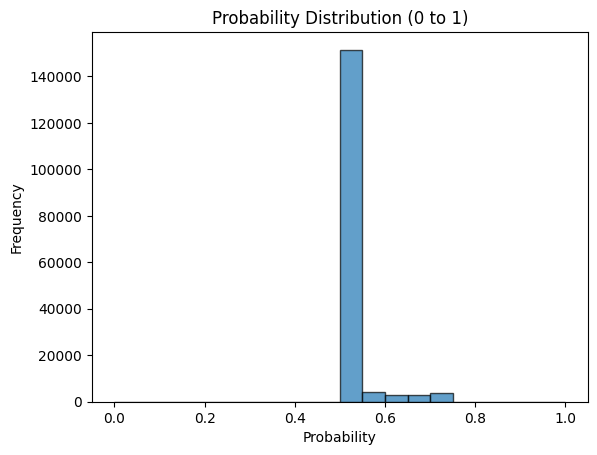

In [ ]:
plt.hist(probas, bins=20, range=(0, 1), edgecolor='black', alpha=0.7)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution (0 to 1)')
plt.show()

Resta evaluar el poder predictivo de esto, asumiendo que 0.5 podría tomarse como un baja probabilidad de BAJA

In [ ]:
def find_threshold_for_positives(probas, target_positives=11000, tolerance=10):
    threshold = 0.5  # Starting threshold
    step = 0.01      # Initial step size for adjusting the threshold
    max_iter = 10000  # Maximum iterations to avoid infinite loops
    
    for i in range(max_iter):
        # Convert probabilities to binary predictions based on the current threshold
        predictions = (probas >= threshold).astype(int)
        
        # Count the number of positives
        num_positives = predictions.sum()
        
        # Check if the number of positives is within the tolerance range
        if abs(num_positives - target_positives) <= tolerance:
            print(f"Threshold found: {threshold} with {num_positives} positives")
            return threshold, predictions
        
        # Adjust threshold based on whether we have too few or too many positives
        if num_positives < target_positives:
            threshold -= step  # Lower threshold to get more positives
        else:
            threshold += step  # Raise threshold to get fewer positives
        
        # Optional: gradually reduce step size for finer adjustments
        step = max(step * 0.9, 0.0001)  # Ensure step size doesn't go too low

    print("Threshold not found within maximum iterations")
    return None, None

In [ ]:
threshold, predictions = find_threshold_for_positives(probas, target_positives=10968)


Threshold found: 0.5756131145894989 with 10974 positives


Luego, resta comparar las 10970 predicciones positivas, contra los resultados de la competencia

En una "late submition"


In [ ]:
submission = pd.DataFrame({
    'numero_de_cliente': X_.numero_de_cliente.values,
    'Predicted': predictions
})

# Nombre del archivo de salida
output_file = f"late_sub_xgb+dl_att_02.csv"

# Guardar el DataFrame en un archivo CSV
submission.to_csv(output_file, index=False)
print(f"Predicciones guardadas en {output_file}")

Predicciones guardadas en late_sub_xgb+dl_att_02.csv


In [ ]:
len(submission)

164876

El resultado es lamentable, con un redimiento negativo, según se observa a continuación

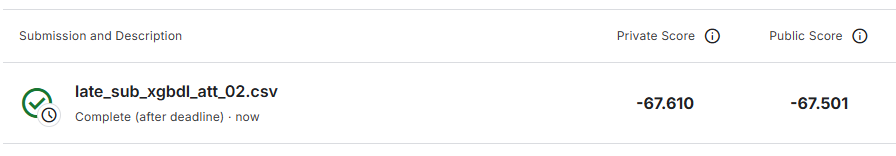

## Conclusiones

El fracaso de este experimento no quita la ganancia en apredizaje relacionado con soluciones "creativas" para problemas de la industria de la Ciencia de datos.

Las posibles causas que estimo para esto, más allá de *posibles errores no forzados* que pude cometer durante este experimento, son:

**Escases de muestras**

Los modelos que utilizan mecanismos de atención suelen ser entrenados con millones de muestras de texto, obtenidas desde internet, permitiendo que estos aprendan patrones sutiles de las mismas.

En este caso, solo estamos trabajando con unas 200 mil muestras, de las cuales a penas 1000 son casos positivos (0.5 %). En el experimento con datos aduaneros, pude trabajar con más de 6 millones de muestras con un 3 % de positivos.

**Desconocimiento del negocio**

En el caso de fraude aduanero, según se explica en el paper "DATE: Dual Attentive Tree-aware Embedding for Customs Fraud Detection", se utilizan atributos "especiales" (id del importador y código tarifario de la mercadería) para enriquecer el mecanismo de atención. En este caso, se optó por omitir este enriquecimiento, a falta de conocimiento del negocio.

**Falta de regularización**

En el caso original, en el que se implementó esta arquitectura para fraude aduanero, se utilizaron "ataques" para penalizar la función de pérdida con casos atípicos. Otra técnica que puede usarse es el conocido drop-out, aunque en este experimento ninguna de estas es utilizada y el overfitting es evidente de las gráficas de aprendizaje. A mi entender, esto no justifica los pésimos resultados, pero sí debe ser tenido en cuenta si se pretende su replica en otros casos a futuro.